# Test DRDV Policy  with Engine Failure

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Mars3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_Meta-Learning-master/Experiments/Mars3DOF/Sensor_noise


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
queue fixed
Flat Constraint


<IPython.core.display.Javascript object>


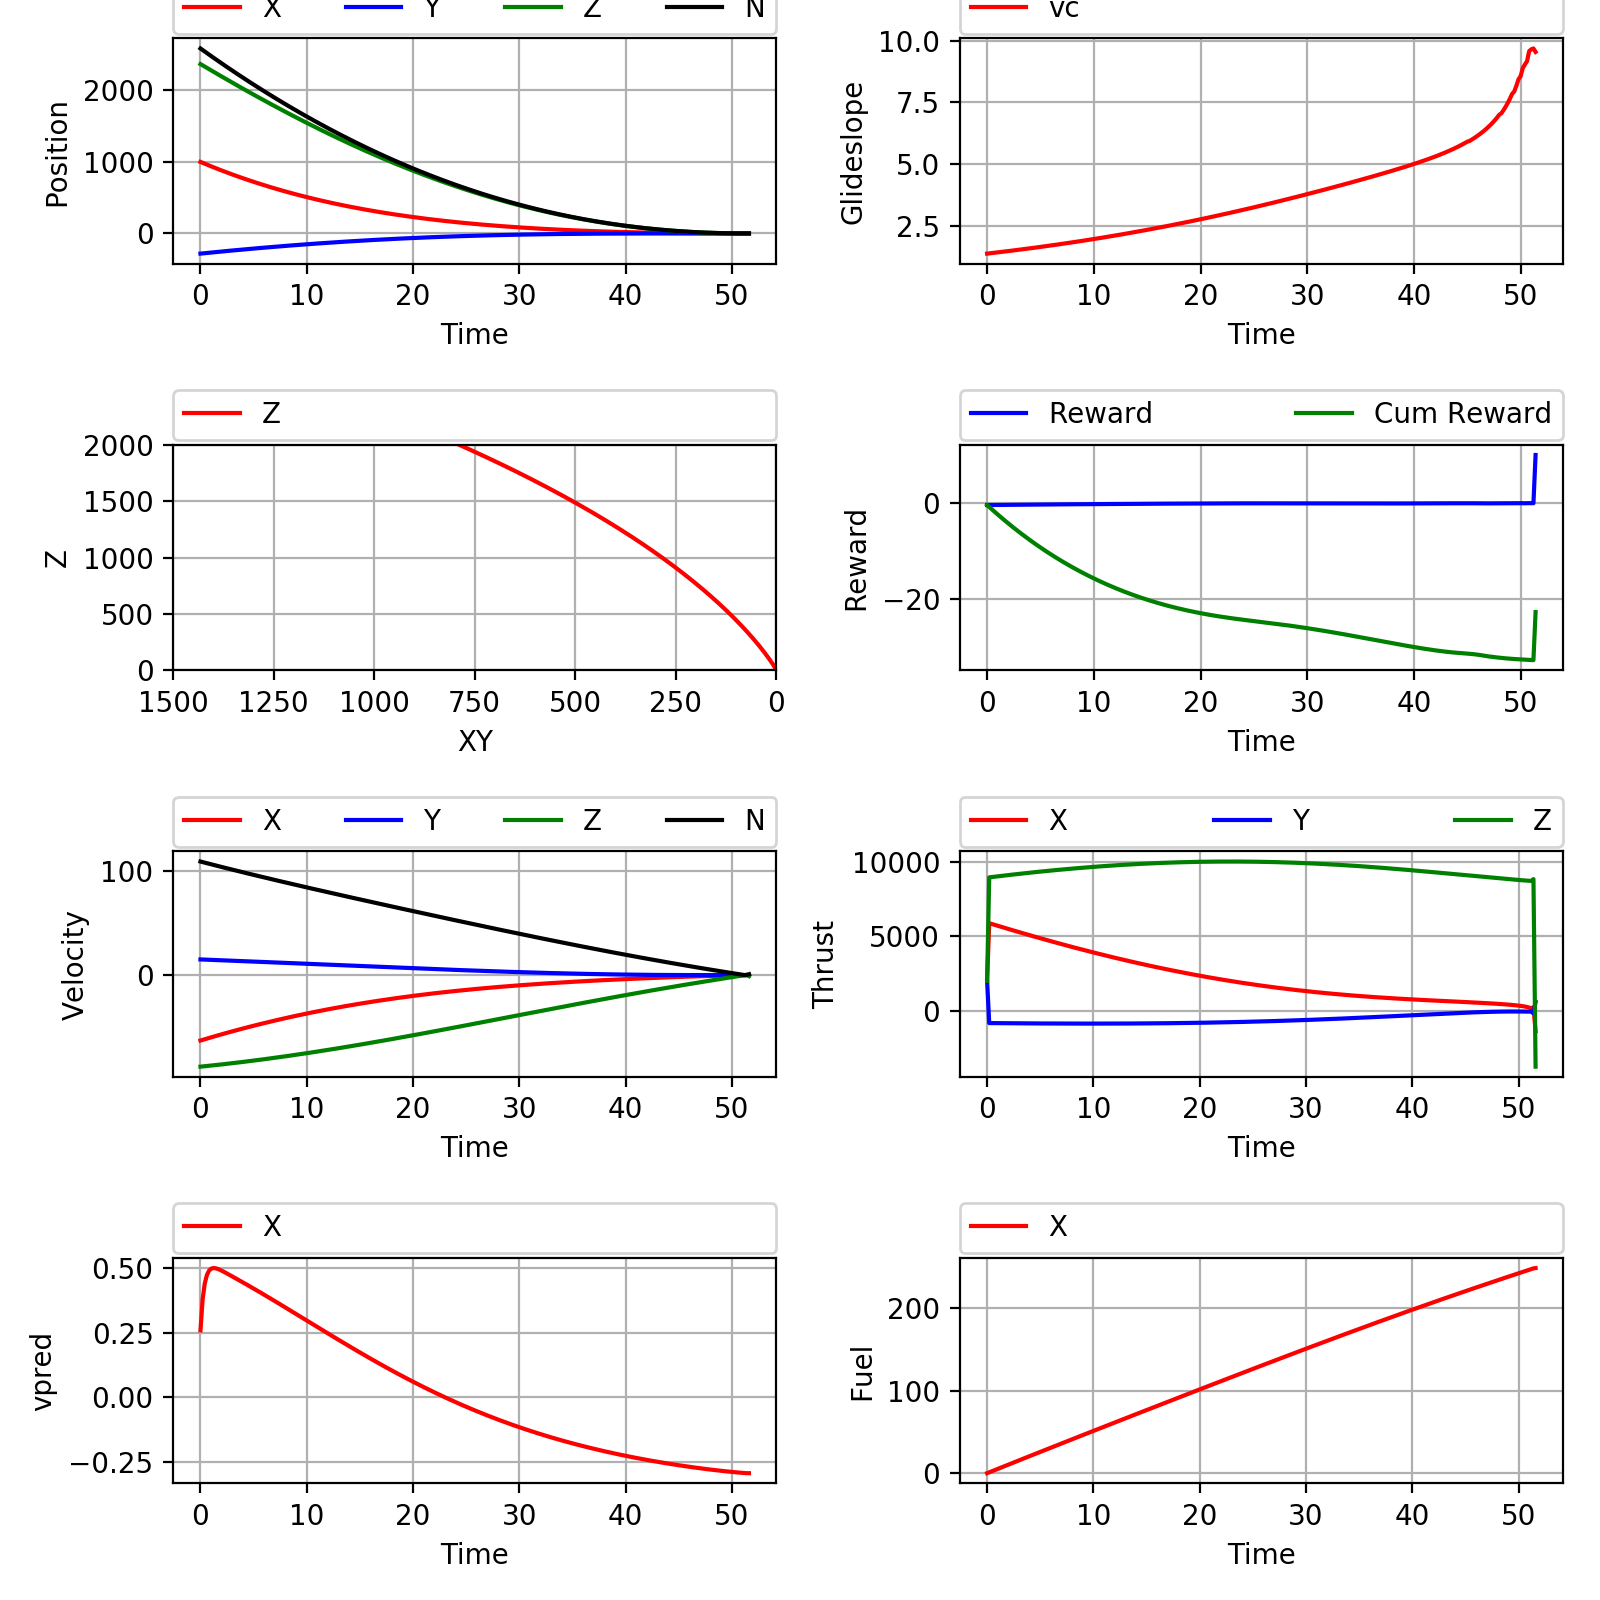

<IPython.core.display.Javascript object>


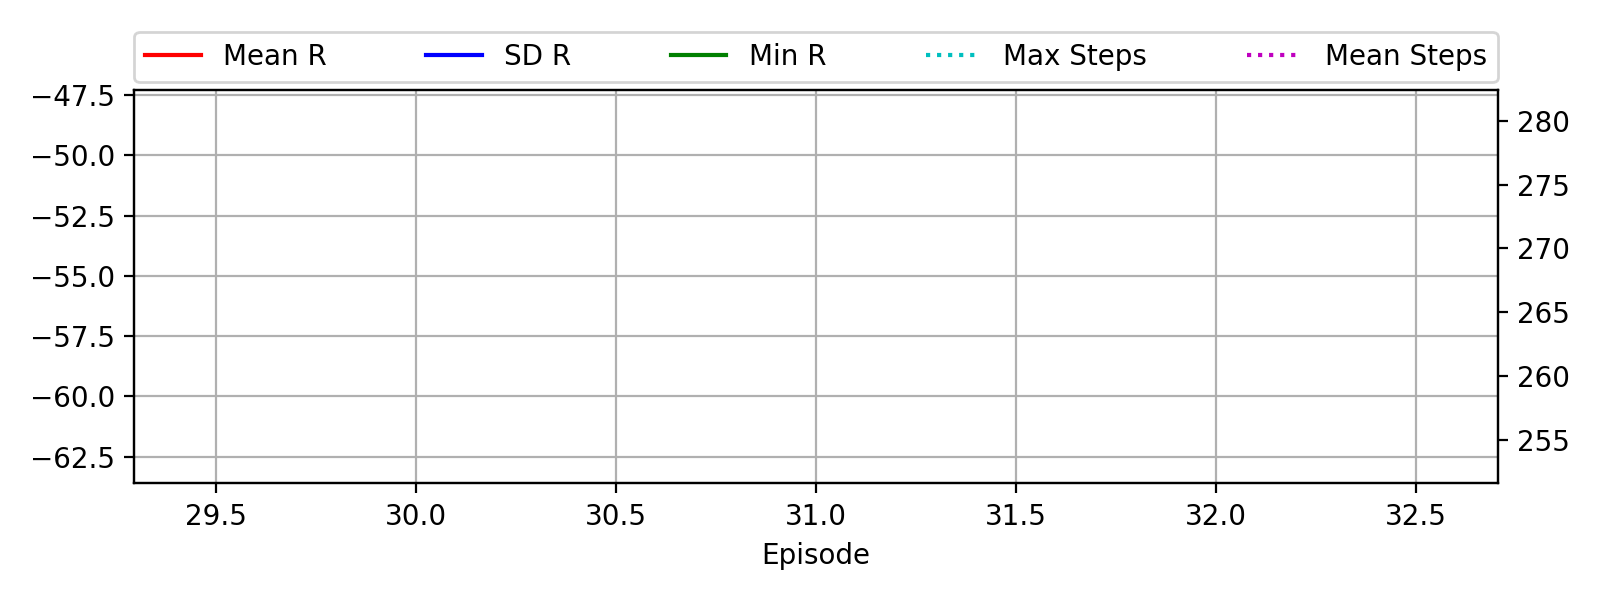

<IPython.core.display.Javascript object>


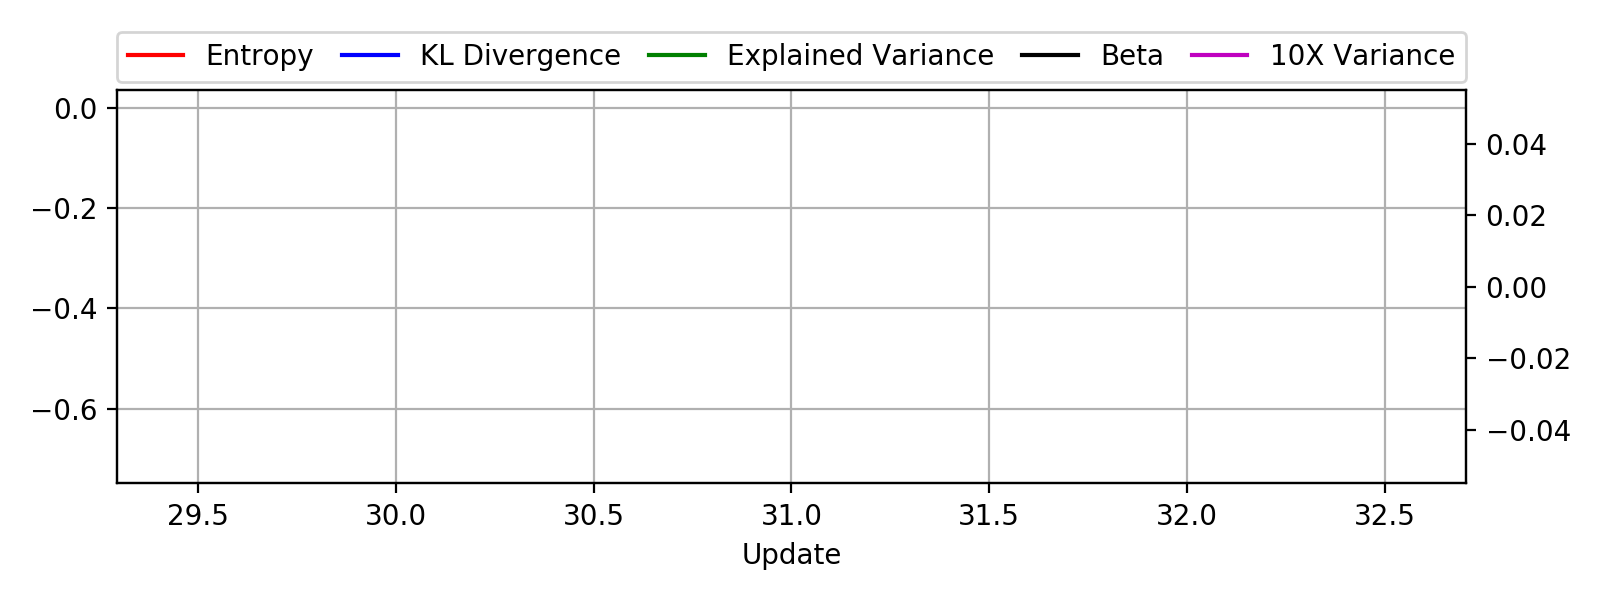

<IPython.core.display.Javascript object>


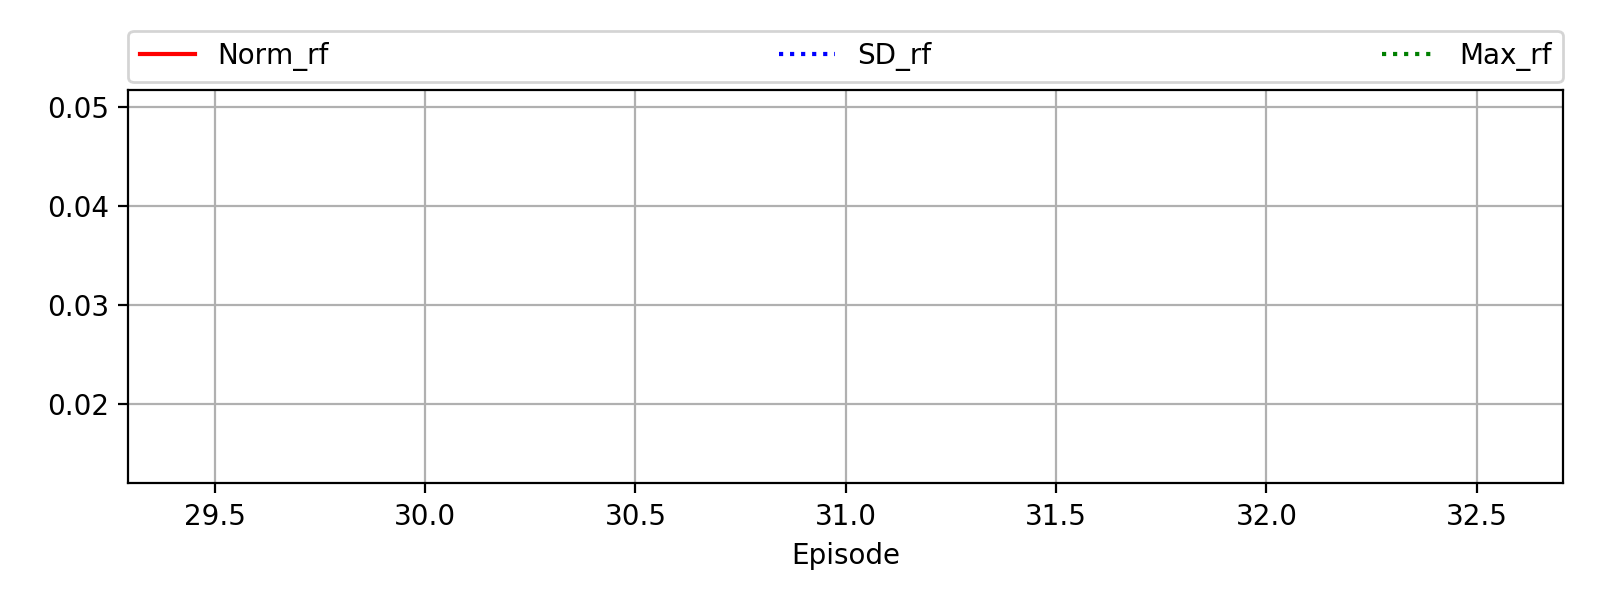

<IPython.core.display.Javascript object>


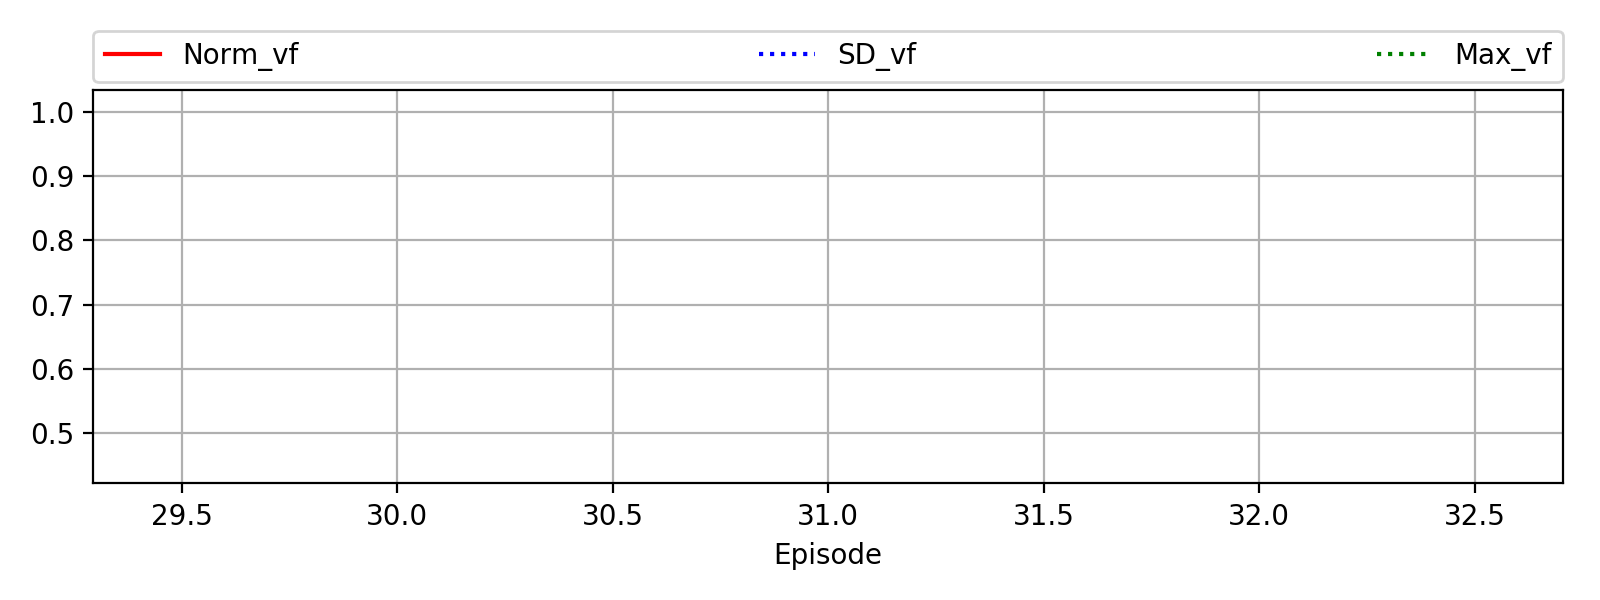

Lander Env
Landing_icgen:
    nominal_g                   :  -3.7114
    downrange                   :  (0, 2000, -70, -10)
    crossrange                  :  (-1000, 1000, -30, 30)
    altitude                    :  (2300, 2400, -90, -70)
    adjust_apf_v0               :  True
Value Funtion
	xn_init: layer  Linear(in_features=6, out_features=60, bias=True)
	xn_init: layer  GRUCell(60, 17)
	xn_init: layer  Linear(in_features=17, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Function: recurrent steps > 1, disabling shuffle and batching
	Clip Range:         0.5
	Shuffle :           False
	Batch Size :        9999999
	Max Grad Norm:      30
	Recurrent Steps:    20
	Rollout Limit:      1
Agent
*** SCALER WARMUP COMPLETE *** 
ValFun  Gradients: u/sd/Max/C Max/Max u/Max sd :   0.1470   0.1287   0.5570   0.5570   0.1470   0.1287
Update Cnt = 0    ET =     30.1   Stats:  Mean, Std, Min, Max
r_f      |    -0.0    -0.0    -0.0 |     0.0     0

In [3]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model_noise import Lander_model
from ic_gen2 import Landing_icgen
import rl_utils

from arch_policy_vf import Arch


from policy_drdv import Policy
from value_function import Value_function


import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model()
lander_model = Lander_model(apf_tau1=20,apf_tau2=100,apf_vf1=-2,apf_vf2=-1,apf_v0=70,apf_atarg=15., 
                            sensor_pos_bias_range=(-0.08,0.08), sensor_vel_bias_range=(-0.10,0.10))
lander_model.get_state_agent = lander_model.get_state_agent1

obs_dim = 6
act_dim = 3
recurrent_steps = 20

reward_object = Reward()

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=100.0,print_every=10)

env.ic_gen = Landing_icgen(mass_uncertainty=0.05, 
                           g_uncertainty=(0.05,0.05),
                           adjust_apf_v0=True,
                          downrange = (0,2000 , -70, -10), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70))
env.ic_gen.show()

arch = Arch()

policy = Policy(env)
value_function = Value_function(valfunc_nets.GRU(obs_dim, recurrent_steps=recurrent_steps), 
                                shuffle=False, batch_size=9999999, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
agent.train(3)

# Test Policy 

In [4]:
policy.test_mode=True

env.test_policy_batch(agent,5000,print_every=100)

i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |10328.57 |1253.49 |3155.26 |15000.00 |    56
glideslope | 2.248 | 3.391 | 0.079 |80.043 |    65
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.511 |   0.881 |   0.002 |   8.871
norm_rf  |     0.0 |     0.0 |     0.0 |     0.5
position |    -0.0     0.0    -0.0 |     0.0     0.0     0.0 |    -0.1    -0.0    -0.0 |     0.1     0.4    -0.0
velocity |  -0.106  -0.053  -0.390 |   0.233   0.379   0.821 |  -0.809  -3.241  -8.248 |   0.506   0.498   0.024
fuel     |257.61 | 19.74 |219.41 |312.08
glideslope |  4.90 | 10.57 |  0.08 | 59.21
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |10292.70 |1198.45 |2984.98 |15000.00 |    56
glideslope | 2.670 |17.149 | 0.079 |3284.856 |   187
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.480 |   0.657 |   0.000 |   8.871
norm_rf  |     0.0 |     0.0 |     0.0 |     0.5
position |    

i :  1400
Cumulative Stats (mean,std,max,argmax)
thrust   |10281.41 |1200.78 |2000.00 |15000.00 |   283
glideslope | 2.639 | 9.575 | 0.079 |3284.856 |   187
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.440 |   0.503 |   0.000 |  10.970
norm_rf  |     0.0 |     0.2 |     0.0 |     5.9
position |    -0.0    -0.0    -0.0 |     0.0     0.2     0.0 |    -0.9    -5.9    -0.1 |     0.1     3.6    -0.0
velocity |  -0.054  -0.006  -0.347 |   0.203   0.289   0.445 |  -1.031  -4.528  -9.688 |   1.220   5.141   0.045
fuel     |257.59 | 18.56 |210.80 |313.58
glideslope |  8.46 | 37.41 |  0.08 |1148.75
i :  1500
Cumulative Stats (mean,std,max,argmax)
thrust   |10290.25 |1202.65 |2000.00 |15000.00 |   283
glideslope | 2.677 | 9.654 | 0.079 |3284.856 |   187
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.443 |   0.507 |   0.000 |  10.970
norm_rf  |     0.0 |     0.2 |     0.0 |     5.9
position 

i :  2700
Cumulative Stats (mean,std,max,argmax)
thrust   |10289.45 |1216.88 |2000.00 |15000.00 |   283
glideslope | 2.736 | 9.355 | 0.052 |3284.856 |   187
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.460 |   0.651 |   0.000 |  15.998
norm_rf  |     0.0 |     0.6 |     0.0 |    25.6
position |     0.0    -0.0    -0.0 |     0.3     0.5     0.0 |    -0.9   -24.7    -0.5 |    11.1     3.6    -0.0
velocity |  -0.059   0.001  -0.366 |   0.309   0.342   0.533 |  -8.839  -4.528 -12.066 |   1.374   9.978   0.045
fuel     |257.18 | 18.69 |205.01 |331.02
glideslope |  8.53 | 38.40 |  0.05 |1207.16
i :  2800
Cumulative Stats (mean,std,max,argmax)
thrust   |10285.02 |1216.39 |2000.00 |15000.00 |   283
glideslope | 2.721 | 9.204 | 0.052 |3284.856 |   187
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.460 |   0.641 |   0.000 |  15.998
norm_rf  |     0.0 |     0.6 |     0.0 |    25.6
position 

i :  4000
Cumulative Stats (mean,std,max,argmax)
thrust   |10287.10 |1215.29 |2000.00 |15000.00 |   283
glideslope | 2.712 | 8.639 | 0.052 |3284.856 |   187
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.469 |   0.730 |   0.000 |  15.998
norm_rf  |     0.0 |     0.8 |     0.0 |    25.8
position |     0.0    -0.0    -0.0 |     0.6     0.5     0.0 |    -0.9   -24.7    -0.5 |    25.0     8.1    -0.0
velocity |  -0.066   0.008  -0.368 |   0.376   0.370   0.579 |  -9.948  -5.233 -14.059 |   2.260   9.978   0.045
fuel     |257.41 | 18.62 |198.74 |331.02
glideslope |  8.35 | 34.63 |  0.05 |1207.16
i :  4100
Cumulative Stats (mean,std,max,argmax)
thrust   |10285.42 |1215.23 |2000.00 |15000.00 |   283
glideslope | 2.721 | 8.627 | 0.052 |3284.856 |   187
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.468 |   0.723 |   0.000 |  15.998
norm_rf  |     0.0 |     0.8 |     0.0 |    25.8
position 